## Numerical Solution

### Imports

In [43]:
import numpy as np
import scipy.linalg as la
from scipy.integrate import quad
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')
from tqdm import tqdm
import pandas as pd
from typing import Callable

### Background

First I will calculate a numerical solution. I decided to go with a simple implicit finite difference solution method, the Crank-Nicolson method. I figured this was a good choice as the diffusion equation is stiff so implicit methods can reduce the error from large timesteps. I'll start with the homogeneuos equation, then add in the reaction term.

$$
\frac{\partial C}{\partial t} = D \frac{\partial^2 C}{\partial x^2} - kC
$$

The Crank-Nicolson method discretizes the diffusion equation into a finite differences in space and time. The $t$ and $x$ discretizations are defined as follows:

$$
\begin{align}
x_i = x_0 + i \Delta x, \qquad i = 0,1,\dots,N_x
\\[1em]
t_n = t_0 + n \Delta t, \qquad n = 0,1,\dots, N_t
\end{align}
$$

In particular, it uses a trapezoidal approximation to integrating from $t_n$ to $t_{n+1}$, which ends up looking like taking the average of $\frac{\partial^2 C}{\partial x^2}$ between $t_n$ and $t_{n+1}$. This results in a tridiagonal system of equations over the whole discretized spatial coordinate.

$$
\begin{align}
\frac{\partial C}{\partial t} &= D \frac{\partial^2 C}{\partial x^2}
\\[1em]
\frac{\Delta_+ C}{\Delta t} &= D \cdot \text{Avg}_{[n,n+1]} \left(\frac{\Delta^2 C}{\Delta x^2}\right)
\\[1em]
\frac{C_i^{n+1}-C_i^n}{\Delta t} &= D\frac{1}{2}\left(\frac{C_{i-1}^n-2C_i^n+C_{i+1}^n}{\Delta x^2}+\frac{C_{i-1}^{n+1}-2C_i^{n+1}+C_{i+1}^{n+1}}{\Delta x^2}\right)
\end{align}
$$

With some rearranging, this gives a general formula for how to get $C_i^{n+1}$ for all positions $x_i$, given knowledge of $C_i^n$. For Dirichlet boundaries, the concentration is just 0 at $x = 0$ and $x=L$, i.e., $x_0$ and $x_{N_x}$. They won't effect the rest of the substrate and we can ignore them as long as $C^n[0]=C^n[-1]=0$ is enforced for all n (more on this later).

$$
A \bold{C}^{n+1} = B \bold{C}^n

\\[1em]

r = \frac{D \Delta t}{2 \Delta x^2}

\\[1em]

A = \begin{bmatrix}
    (1+2r) & -r & & & & \\
    -r & (1+2r) & -r & & & \\
      & -r & (1+2r) & -r & & \\
      & & \ddots & \ddots & \ddots & \\
      & & & -r & (1+2r) & -r \\
      & & & & -r & (1+2r)
\end{bmatrix}

\\[1em]

B = \begin{bmatrix}
    (1-2r) & r & & & & \\
    r & (1-2r) & r & & & \\
      & r & (1-2r) & r & & \\
      & & \ddots & \ddots & \ddots & \\
      & & & r & (1-2r) & r \\
      & & & & r & (1-2r)
\end{bmatrix}
$$


From here, it's pretty straighforward (at least numerically) to add in the $kC$ reaction term: it just adjusts the concentration by $-\Delta t k C_i$ each timestep, at each point $x_i$. This is called an implicit/explicit (IMEX) method, because the spatial/laplacian term is determined implicitly with Crank-Nicolson while the reaction term is determined with explicit Euler.

$$
A \bold{C}^{n+1} = B \bold{C}^n - \Delta t k \bold{C}^n
$$

### Neumann Boundary Conditions

A more physical boundary is to have $\frac{\partial C}{\partial x} = 0$ at $x_0$ and $x_{N_x}$, i.e, there is no flux of concentration into or out of the boundary.

Thus, using central differences at $C_0$ and $C_{N_x}$:

$$
\begin{align}
\frac{C_1-C_{-1}}{2 \Delta x} = 0 \rightarrow C_1 = C_{-1} \qquad &\text{and} \qquad \frac{C_{N_x+1}-C_{N_x-1}}{2 \Delta x} = 0 \rightarrow C_{N_x-1} = C_{N_x+1}
\\[1em]
\frac{\Delta^2 C_0}{\Delta x^2} = \frac{C_{-1}-2C_0+C_{1}}{\Delta x^2} = \frac{2C_{1}-2C_0}{\Delta x^2} \qquad &\text{and} 
\qquad \frac{\Delta^2 C_{N_x}}{\Delta x^2} = \frac{C_{N_x-1}-2C_{N_x}+C_{N_x+1}}{\Delta x^2} = \frac{2C_{N_x-1}-2C_{N_x}}{\Delta x^2}
\end{align}
$$

The result is simply that the off-diagonal coefficients are doubled in the matrices A and B at the boundaries.

$$
A = \begin{bmatrix}
    (1+2r) & \mathbf{-2r} & & & & \\
    -r & (1+2r) & -r & & & \\
      & -r & (1+2r) & -r & & \\
      & & \ddots & \ddots & \ddots & \\
      & & & -r & (1+2r) & -r \\
      & & & & \mathbf{-2r} & (1+2r)
\end{bmatrix}

\\[1em]

B = \begin{bmatrix}
    (1-2r) & \mathbf{2r} & & & & \\
    r & (1-2r) & r & & & \\
      & r & (1-2r) & r & & \\
      & & \ddots & \ddots & \ddots & \\
      & & & r & (1-2r) & r \\
      & & & & \mathbf{2r} & (1-2r)
\end{bmatrix}
$$

Also, we can now check that the solution actually makes sense by accounting for conservation of the solute.

### Limits on Stability


An IMEX solution does have the downside that with the addition of an explicit term on the right hand side, the solution is no longer unconditionally stable. Instead, the size of the timesteps must be deterined to fit the stability condition:

$$
\Delta t \leq \frac{2}{k}
$$

--------------

---NOT TRUE: ---

Additionally, while Crank-Nicolson is unconditionally stable, it still isn't L-stable and will cause spurious oscillations from very still terms/large eigenvalues. This can be minimized by keeping the values of $r$, which roughly measures the stiffness of the equation, below 0.25. Lower $r$ can further reduce stiffness issues.

$$
\begin{align}
\Delta  x = \sqrt{ \frac{D \Delta t}{2r} },  \qquad    r \lesssim 0.25
\end{align}
$$

### Implementation

In [33]:
def imex_dirichlet_constrained(C0: Callable, D, L, k, tf, Nt=500, r=0.25, x_scale=None):
    '''
    Uses CN propogation to find concentration profile over time. 
    Includes explicit reaction term.
    Uses boundary condition C(0,0)=C(0,L)=0.
    dx, dt constrained by stiffness parameter.

    C0: function that represents the concentration profile at t=0.
    D: diffusion coefficient
    L: length of rod
    k: Reaction coefficient
    tf: final time
    Nt: Number of time steps, used to determine dt and dx by stiffness relation
    r: Stiffness parameter, should be equal to or higher than 0.25
    x_scale: Optional rescale of x grid points.
    '''

    dt = tf/(Nt-1)
    dx = np.sqrt( (D*dt)/(2*r) )
    Nx = int(L/dx)
    dx = L/(Nx-1)
    
    if k!=0 and dt > 2/k: 
        print('WARNING: dt outside of stability conditions!')

    A_bands = np.zeros((3,Nx))
    A_bands[0,1:] = -r
    A_bands[1,:] = 1+2*r
    A_bands[2,:-1] = -r
    B = np.diag((1-2*r) * np.ones(Nx)) + np.diag(r*np.ones(Nx-1), k=+1)+np.diag(r*np.ones(Nx-1), k=-1)

    C = np.empty((Nt+1, Nx)) # (n,i)
    xgrid = np.linspace(0, L, Nx)
    C[0,:] = C0(xgrid)

    for n in range(Nt):
        RHS = B@C[n] - dt*k*C[n]
        # Enforce Dirichlet Boundary
        RHS[0]=0
        RHS[-1]=0
        C[n+1,:]=la.solve_banded((1,1), A_bands, RHS) # (1,1) denotes A has 1 diagonal row above main diag, 1 below.

    # Rescale output x spacing (old method)
    if x_scale is not None:
        C_rescaled = np.empty((N+1, x_scale))
        x_old = xgrid
        x_new = np.linspace(0, L, x_scale)

        for n in range(Nt+1):
            C_rescaled[n] = np.interp(x_new, x_old, C[n])
        
        C = C_rescaled

    return C

def imex_dirichlet(C0: Callable, D, L, k, tf, Nx=500, Nt=500, x_scale=None):
    '''
    Uses CN propogation to find concentration profile over time. 
    Includes explicit reaction term.
    Uses boundary condition C(0,0)=C(0,L)=0.
    dx, dt unconstrained by stiffness parameter.

    C0: function that represents the concentration profile at t=0.
    D: diffusion coefficient
    L: length of rod
    tf: final time
    Nx: Number of space steps. Including the 0th point, returns a maxrix with dimention Nx+1.
    Nt: Number of time steps. Including the 0th point, returns a maxrix with dimention Nt+1.
    x_scale: Optional rescale of x grid points.
    '''

    dt = tf/Nt # t_0 = 0, t_1 = dt, t_2 = 2*dt, ...,t_n = n*dt, t_Nt = Nt*dt = tf
    dx = L/Nx # x_0 = 0, x_1 = dx, x_2 = 2*dx, ..., x_i = i*dx, x_Nx = Nx*dx = L
    r = (D*dt)/(2*dx**2)
    
    if k!=0 and dt > 2/k: 
        print('WARNING: dt outside of stability conditions!')

    A_bands = np.zeros((3,Nx+1)) # Diagonal matrix; diagonal elements from i=0 to i=Nx
    A_bands[0,1:] = -r
    A_bands[1,:] = 1+2*r
    A_bands[2,:-1] = -r
    B = np.diag((1-2*r) * np.ones(Nx+1)) + np.diag(r*np.ones(Nx), k=+1)+np.diag(r*np.ones(Nx), k=-1)

    C = np.empty((Nt+1, Nx+1)) # (n,i) from (0,0) to (Nt, Nx)
    xgrid = np.linspace(0, L, Nx+1)
    C[0,:] = C0(xgrid)

    for n in range(Nt):
        RHS = B@C[n] - dt*k*C[n]
        # Enforce Dirichlet Boundary
        RHS[0]=0
        RHS[-1]=0
        C[n+1,:]=la.solve_banded((1,1), A_bands, RHS) # (1,1) denotes A has 1 diagonal row above main diag, 1 below.

    # Rescale output x spacing (old method)
    if x_scale is not None:
        C_rescaled = np.empty((Nt+1, x_scale))
        x_old = xgrid
        x_new = np.linspace(0, L, x_scale)

        for n in range(Nt+1):
            C_rescaled[n] = np.interp(x_new, x_old, C[n])
        
        C = C_rescaled

    return C

def imex_neumann(C0: Callable, D, L, k, tf, Nx=500, Nt=500, x_scale=None):
    '''
    Uses CN propogation to find concentration profile over time. 
    Includes explicit reaction term.
    Uses neumann boundary condition of 0 flux at boundaries.
    dx, dt unconstrained by stiffness parameter.

    C0: function that represents the concentration profile at t=0.
    D: diffusion coefficient
    L: length of rod
    tf: final time
    Nx: Number of space steps. Including the 0th point, returns a maxrix with dimention Nx+1.
    Nt: Number of time steps. Including the 0th point, returns a maxrix with dimention Nt+1.
    x_scale: Optional rescale of x grid points.
    '''

    dt = tf/Nt # t_0 = 0, t_1 = dt, t_2 = 2*dt, ...,t_n = n*dt, t_Nt = Nt*dt = tf
    dx = L/Nx # x_0 = 0, x_1 = dx, x_2 = 2*dx, ..., x_i = i*dx, x_Nx = Nx*dx = L
    r = (D*dt)/(2*dx**2)
    
    if k!=0 and dt > 2/k: 
        print('WARNING: dt outside of stability conditions!')

    A_bands = np.zeros((3,Nx+1)) # Diagonal matrix; diagonal elements from i=0 to i=Nx
    A_bands[0,1:] = -r
    A_bands[1,:] = 1+2*r
    A_bands[2,:-1] = -r
    B = np.diag((1-2*r) * np.ones(Nx+1)) + np.diag(r*np.ones(Nx), k=+1)+np.diag(r*np.ones(Nx), k=-1)

    # Adjust for Neumann conditions:
    A_bands[0,1] = -2*r
    A_bands[2,-2] = -2*r
    B[0,1] = 2*r
    B[-1,-2] = 2*r

    C = np.empty((Nt+1, Nx+1)) # (n,i) from (0,0) to (Nt, Nx)
    xgrid = np.linspace(0, L, Nx+1)
    C[0,:] = C0(xgrid)

    for n in range(Nt):
        RHS = B@C[n] - dt*k*C[n]
        C[n+1,:]=la.solve_banded((1,1), A_bands, RHS) # (1,1) denotes A has 1 diagonal row above main diag, 1 below.

    # Rescale output x spacing (old method)
    if x_scale is not None:
        C_rescaled = np.empty((Nt+1, x_scale))
        x_old = xgrid
        x_new = np.linspace(0, L, x_scale)

        for n in range(Nt+1):
            C_rescaled[n] = np.interp(x_new, x_old, C[n])
        
        C = C_rescaled

    return C

def analytic_dirichlet(C0: Callable, D, L, k, tf, Nx=500, M=100):
    '''
    An analytic solution to compare results with.
    Uses Dirichlet conditions at boundaries
    **Only works with constant initial concentrations.**
    
    Nx: Number of space steps. Including the 0th point, returns a maxrix with dimention Nx+1.
    M: The number of fourier terms computed in the infinite sum.
    '''
    C_0 = C0(0)
    x = np.linspace(0, L, Nx+1)
    C = np.zeros_like(x)
    for m in range(1, M+1):
        bm = ((2.0*C_0)/(m*np.pi))*(1 - (-1)**m)
        C += bm * np.sin((m*np.pi*x)/L) * np.exp(-(k + D*((m*np.pi)/L)**2)*tf)
    return C

def analytic_neumann(C0: Callable, D, L, k, tf, Nx=500, M=100):
    '''
    An analytic solution to compare results with.
    Uses Neumann conditions at boundaries.
    Works for any initial concentration profile which can be expressed as a Fourier cosine series.
    
    Nx: Number of space steps. Including the 0th point, returns a maxrix with dimention Nx+1.
    M: The number of fourier terms computed in the infinite sum.
    '''

    x = np.linspace(0, L, Nx+1)

    a0 = (1/L)*quad(C0, 0, L)[0] # quad returns (answer, err)
    C = np.zeros_like(x) + a0*np.exp(-k * tf)
    for m in range(1, M+1):
        f = lambda x: C0(x)*np.cos((m*np.pi*x) / L)
        am= (2/L)*quad(f, 0, L)[0] 

        C += am * np.cos((m*np.pi*x) / L) * np.exp( -(D*((m*np.pi)/L)**2 + k) * tf )

    return C


### Testing Numerical vs. Analytic Solution

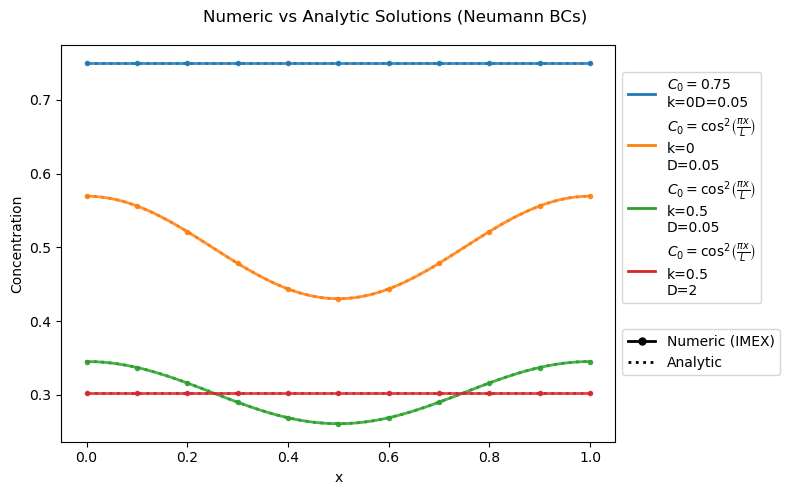

In [ ]:
# Plotting some numeric vs analytic solutions (Source: ChatGPT)
analytic = analytic_neumann
numeric  = imex_neumann

params = {
    "D": 0.05,
    "L": 1,
    "k": 0,
    "tf": 1
}

L  = params["L"]
Nx = 100
x  = np.linspace(0, L, Nx+1)

cases = [
    {
        "C0": lambda x: 0.75,
        "k": 0,
        "D": 0.05,
        "label": r"$C_0 = 0.75$" + '\n' + "k=0" + 'D=0.05',
        "color": "C0"
    },
    {
        "C0": lambda x: np.cos(np.pi*x/L)**2,
        "k": 0,
        "D": 0.05,
        "label": r"$C_0 = \cos^2\!\left(\frac{\pi x}{L}\right)$" + '\n' + "k=0" + '\n' + 'D=0.05',
        "color": "C1"
    },
    {
        "C0": lambda x: np.cos(np.pi*x/L)**2,
        "k": 0.5,
        "D": 0.05,
        "label": r"$C_0 = \cos^2\!\left(\frac{\pi x}{L}\right)$" + '\n' + "k=0.5" + '\n' + 'D=0.05',
        "color": "C2"
    },
    {
        "C0": lambda x: np.cos(np.pi*x/L)**2,
        "k": 0.5,
        "D": 2,
        "label": r"$C_0 = \cos^2\!\left(\frac{\pi x}{L}\right)$" + '\n' + "k=0.5" + '\n' + 'D=2',
        "color": "C3"
    }
]

plt.figure(figsize=(8,5))

for case in cases:
    params["C0"] = case["C0"]
    params["k"]  = case["k"]
    params["D"]  = case["D"]

    C_an  = analytic(**params, Nx=Nx)
    C_num = numeric(**params, Nx=Nx)[-1]

    # Numeric solution: solid line + markers
    plt.plot(
        x, C_num,
        color=case["color"],
        linestyle="-",
        linewidth=2,
        marker="o",
        markersize=3,
        markevery=10,
        alpha=0.85
    )

    # Analytic solution: dotted line
    plt.plot(
        x, C_an,
        color=case["color"],
        linestyle=":",
        linewidth=2
    )

plt.xlabel("x")
plt.ylabel("Concentration")
plt.suptitle("Numeric vs Analytic Solutions (Neumann BCs)")

# Legend for initial conditions (colors)
ic_handles = [
    Line2D([0], [0], color=case["color"], lw=2, label=case["label"])
    for case in cases
]
legend1 = plt.legend(handles=ic_handles, loc='upper left', bbox_to_anchor=(1, 0.95))
plt.gca().add_artist(legend1)

# Legend for method (linestyle)
method_handles = [
    Line2D([0], [0], color="black", lw=2, linestyle="-",
           marker="o", markersize=5, label="Numeric (IMEX)"),
    Line2D([0], [0], color="black", lw=2, linestyle=":",
           label="Analytic")
]
plt.legend(handles=method_handles, loc='lower left', bbox_to_anchor=(1, 0.15))

plt.tight_layout()
plt.show()


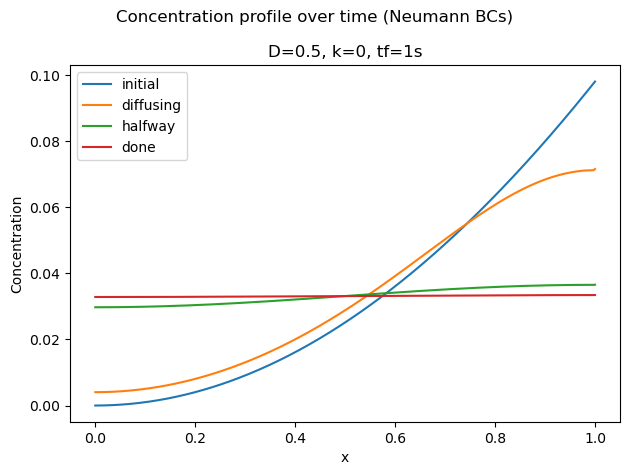

Total Solute:
t=0.00s: 0.0331
t=0.04s: 0.0331
t=0.50s: 0.0331
t=1.00s: 0.0331


In [63]:
# Testing conservation of solute
numeric = imex_neumann

C0 = lambda x: np.sin(x/(np.pi))**2  
D = 0.5
L = 1
k = 0
tf = 1


C = numeric(C0, D, L, k, tf)

x = np.linspace(0, L, C.shape[1])
dt = tf/C.shape[0]
dx = L/C.shape[1]

plt.plot(x, C[0], label='initial')
plt.plot(x, C[20], label = 'diffusing')
plt.plot(x, C[250], label = 'halfway')
plt.plot(x, C[-1], label='done')
plt.xlabel('x')
plt.ylabel('Concentration')
plt.suptitle("Concentration profile over time (Neumann BCs)")
plt.title(f"D=0.5, k=0, tf=1s")
plt.legend()
plt.tight_layout()
plt.show()

print("Total Solute:")
print(f't=0.00s: {np.sum(C[0]*dx):.4f}')
print(f't={20*dt:.2f}s: {np.sum(C[20]*dx):.4f}')
print(f't={250*dt:.2f}s: {np.sum(C[250]*dx):.4f}')
print(f't=1.00s: {np.sum(C[-1]*dx):.4f}')


In [64]:
# Animation
numeric = imex_neumann

C0 = lambda x: np.arccos(x)**2  
D = 0.5
L = 1
k = 0
tf = 1

C = numeric(C0, D, L, k, tf)
x = np.linspace(0,L,C.shape[1])
frames = C.shape[0]

fig, ax = plt.subplots()
line, = ax.plot(x,C[0]) # Creates a blank line object to animate

def update(frame):
    line.set_ydata(C[frame,:])
    return line,

ani = FuncAnimation(fig, func=update, frames=frames, blit=True)
plt.close(fig)
ani

### Testing Accuracy vs. N Timesteps

In [69]:
def test_accuracy(
        solver: Callable, 
        N_range: tuple, 
        analytic: Callable,
        err_func: Callable, 
        params: dict,
        store_soln_data = False
    ):
    '''
    Tests the accurary of the numerical solution vs the analytic solution over a range of Nx and Nt.
    Currently only works for constant C0 since the analytic solution is only valid for constant C0.

    solver: the solver being tested
    N_range: tuple with the lower and upper N (number of timesteps and spatial steps) being calculated, and what to scale by. 
                Since each term must be a multuple of the last, the last term rounds up to the nearest power of the "scale by" factor.
    err_func: how the discrepancy between the numeric and analytic solution is calculated.
    Params: Dict containing the params for the solver. Ex:
        params = {
            "C0": C0,
            "D": D,
            "L": L,
            "k": k,
            "tf": tf
        }
    '''


    N_low = N_range[0]
    N_high = N_range[1]
    if len(N_range) == 2: N_scaleby = 2
    else: N_scaleby = N_range[2]
    if N_scaleby <= 1: raise ValueError("Scale Factor must be > 1")

    
    N_values = []
    N = N_low
    while N < N_high:
        N_values.append(N)
        N *= N_scaleby
    N_values.append(N)  
    N_values = np.array(N_values, dtype=int)


    an_soln = analytic(**params, Nx=N_values[-1])
    

    soln_data_rows = []

    if store_soln_data:

        for Nx in tqdm(N_values, desc="Calculating error"):
            for Nt in tqdm(N_values, leave=False, desc=f'Nx = {Nx}'):

                num_soln = solver(**params, Nx=Nx, Nt=Nt)[-1]
                test_points = np.linspace(0, len(num_soln)-1, N_low, dtype=int) # subsamples evenly spaced points to test with the analytic soln
                num_soln_sampled = num_soln[test_points]                        # This way we're testing the same points no matter the size/x_scale of the soln.
                an_soln_sampled = an_soln[test_points]
                err = err_func(num_soln_sampled, an_soln_sampled)                  

                soln_data_rows.append([Nx, Nt, err, num_soln, num_soln_sampled, an_soln])
                
        soln_data = pd.DataFrame(soln_data_rows, columns=["Nx", "Nt", "Error", "Numeric Solution", "Sampled Numeric Solution", "Analytic Solution"])

    else: 
        for Nx in tqdm(N_values, desc="Calculating error"):
            for Nt in tqdm(N_values, leave=False, desc=f'Nx = {Nx}'):

                num_soln = solver(**params, Nx=Nx, Nt=Nt)[-1]
                test_points = np.linspace(0, len(num_soln)-1, N_low, dtype=int) # subsamples evenly spaced points to test with the analytic soln
                num_soln_sampled = num_soln[test_points]                        # This way we're testing the same points no matter the size/x_scale of the soln.
                an_soln_sampled = an_soln[test_points]
                err = err_func(num_soln_sampled, an_soln_sampled)                  

                soln_data_rows.append([Nx, Nt, err])
                
        soln_data = pd.DataFrame(soln_data_rows, columns=["Nx", "Nt", "Error"])

    return soln_data

def L2norm(num_soln, an_soln):
    '''
    Computes the distance between "points" in the solution vector and analytic solution vector.
    This is normalized by the norm of the analytic solution.  
    '''
    err = np.linalg.norm(num_soln - an_soln) / np.linalg.norm(an_soln)
    return err

Calculating error: 100%|██████████| 8/8 [00:00<00:00, 22.01it/s]


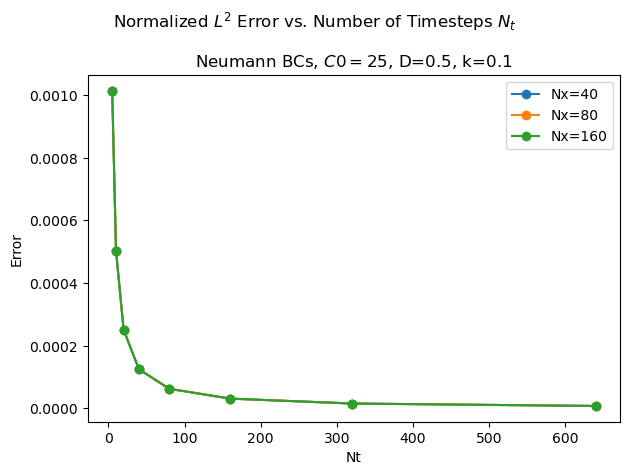

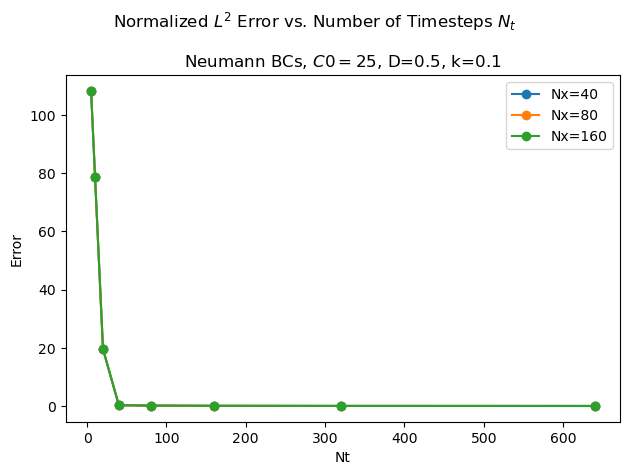

In [73]:
# Plotting some errors

numeric = imex_neumann
analytic = analytic_neumann
N_range = (5,500, 2)
params = {
    "C0": lambda x: 25,
    "D": 0.5,
    "L": 1,
    "k": 0.1,
    "tf": 1
}

plt.figure(1)
costs1 = test_accuracy(numeric, N_range, analytic, L2norm, params)

costs1_40 = costs1.loc[costs1["Nx"]==40]
costs1_80 = costs1.loc[costs1["Nx"]==80]
costs1_160 = costs1.loc[costs1["Nx"]==160]



plt.xlabel('Nt')
plt.ylabel('Error')
plt.suptitle('Normalized $L^2$ Error vs. Number of Timesteps $N_t$')
plt.title(r"Neumann BCs, $C0=25$, D=0.5, k=0.1")

plt.plot(costs1_40["Nt"], costs1_40["Error"], 'o-', label='Nx=40')
plt.plot(costs1_80["Nt"], costs1_80["Error"], 'o-', label='Nx=80')
plt.plot(costs1_160["Nt"], costs1_160["Error"], 'o-', label='Nx=160')
plt.legend()
plt.tight_layout()


plt.figure(2)

L = 1
params = {
    "C0": lambda x: 25*np.cos(np.pi*x / L)**2,
    "D": 20,
    "L": L,
    "k": 5,
    "tf": 1
}
costs1 = test_accuracy(numeric, N_range, analytic, L2norm, params)

costs1_40 = costs1.loc[costs1["Nx"]==40]
costs1_80 = costs1.loc[costs1["Nx"]==80]
costs1_160 = costs1.loc[costs1["Nx"]==160]



plt.xlabel('Nt')
plt.ylabel('Error')
plt.suptitle('Normalized $L^2$ Error vs. Number of Timesteps $N_t$')
plt.title(r"Neumann BCs, $C0=25$, D=0.5, k=0.1")

plt.plot(costs1_40["Nt"], costs1_40["Error"], 'o-', label='Nx=40')
plt.plot(costs1_80["Nt"], costs1_80["Error"], 'o-', label='Nx=80')
plt.plot(costs1_160["Nt"], costs1_160["Error"], 'o-', label='Nx=160')
plt.legend()
plt.tight_layout()

In [10]:
# Little animation

numeric = imex_dirichlet
analytic = analytic_dirichlet
N_range = (5,500, 2)
params = {
    "C0": lambda x: 25,
    "D": 0.5,
    "L": 1,
    "k": 0.1,
    "tf": 1
}

Nx = 160

soln_data = test_accuracy(numeric, N_range, analytic_dirichlet, L2norm, params, store_soln_data=True)

sub_soln_data = soln_data.loc[soln_data["Nx"]==Nx].reset_index(drop=True)

num_solns = sub_soln_data.loc[:, "Numeric Solution"]

an_soln = analytic(**params, Nx=Nx)

plt.figure(2)

frames = len(sub_soln_data.index)
fig, ax = plt.subplots()
x = np.linspace(0, params["L"], Nx)
analytic_line, = ax.plot(x, an_soln)
line, = ax.plot(x,num_solns[0]) # Creates a blank line object to animate

def update(frame):
    line.set_ydata(num_solns[frame])
    return line,

ani = FuncAnimation(fig, func=update, frames=frames, blit=True)
plt.close(fig)
ani

Calculating error: 100%|██████████| 8/8 [00:00<00:00, 12.46it/s]


<Figure size 640x480 with 0 Axes>

## Space-Dependant Diffusion Coefficient

This makes the Crank-Nicolson method slightly more complicated, since you have to average the entire spatial operator $L=\frac{\partial}{\partial x}\left(D(x)\frac{\partial}{\partial x}\right)$ on C between $t_n$ and $t_{n+1}$, not just its second derivative. 
Now the equation becomes: 

$$
\begin{align}
\frac{\partial C}{\partial t} &= \frac{\partial}{\partial x} \left( D(x) \frac{\partial C}{\partial x} \right)
\\[1em]
\frac{\Delta_+ C}{\Delta t} &= \text{Avg}_{[n,n+1]} \left(\frac{1}{\Delta x} \left[ \frac{1}{2}\left(D_i+D_{i+1}\right) \frac{\Delta_+ C}{\Delta x}
                                                                  - \frac{1}{2}\left(D_{i-1}+D_i\right) \frac{\Delta_- C}{\Delta x} \right]\right)
\\[1em]
\alpha_i &= \frac{D_i+D_{i+1}}{2 \Delta x^2}
\\[1em]
\beta_i &=\frac{D_{i-1}+D_i}{2 \Delta x^2}
\\[1em]
\frac{C_i^{n+1}-C_i^n}{\Delta t} &= \frac{1}{2} \left[ \alpha_i(C_{i+1}^{n+1}-C_i^{n+1})-\beta_i(C_i^{n+1}-C_{i-1}^{n+1}) + \alpha_i(C_{i+1}^n-C_i^n)-\beta_i(C_i^n-C_{i-1}^n)  \right]
\\[1em]
r &= \frac{\Delta t}{2}
\\[1em]
A_{i,i-1} &= -\,r\,\beta_i
\\[1em]
B_{i,i-1} &= \;\;r\,\beta_i
\\[1em]
A_{i,i}   &= 1 + r(\alpha_i+\beta_i)
\\[1em]
B_{i,i}   &= 1 - r(\alpha_i+\beta_i)
\\[1em]
A_{i,i+1} &= -\,r\,\alpha_i
\\[1em]
B_{i,i+1} &= \;\;r\,\alpha_i
\\[1em]

A \bold{C}^{n+1} &= B \bold{C}^n - \Delta t k \bold{C}^n

\end{align}

$$

In [11]:
def CN2(C0: Callable, D: Callable, L, k, tf, nspace=500, ntime=500):
    '''
    Uses CN propogation to find concentration profile over time. 
    Uses boundary condition C(0,0)=C(0,L)=D(0)=D(L)=0.

    New: Now D can be variable in x.

    C0: function that represents the concentration profile at t=0.
    D: diffusion coefficient (function of x)
    L: length of rod
    tf: final time
    nspace: number of spatial steps
    ntime: number of timesteps
    '''
    dx = L/(nspace-1)
    dt = tf/(ntime-1)

    Di = np.linspace(0, L, nspace)
    Di[:] = D(Di) # Allows D to still work if it overwrites Di as a non-array, i.e. int/float

    # Initialize alpha_i's, beta_i's - formulas in md above
    alpha = np.zeros_like(Di)
    alpha[:-1] = (Di[:-1]+Di[1:])/(2*dx**2)
    beta = alpha.copy()
    r = dt/2

    # Sets up matrix of A's (off)diagonals to be solved by scipy solve_banded.
    A_bands = np.zeros((3,nspace))
    A_bands[0,1:] = -r*alpha[:-1]
    A_bands[1,:] = 1+r*(alpha+beta)
    A_bands[2,:-1] = -r*beta[:-1]

    B = np.diag(1-r*(alpha+beta)) + np.diag(r*alpha[:-1], k=+1)+np.diag(r*beta[:-1], k=-1)

    C = np.empty((ntime+1, nspace)) # (n,i)
    C[0,:] = C0(np.linspace(0, L, nspace))

    for n in range(ntime):
        b = B@C[n] - dt*k*C[n]
        b[0]=0
        b[-1]=0
        C[n+1,:]=la.solve_banded((1,1), A_bands, b) # (1,1) denotes A has 1 diagonal row above main diag, 1 below.

    return C

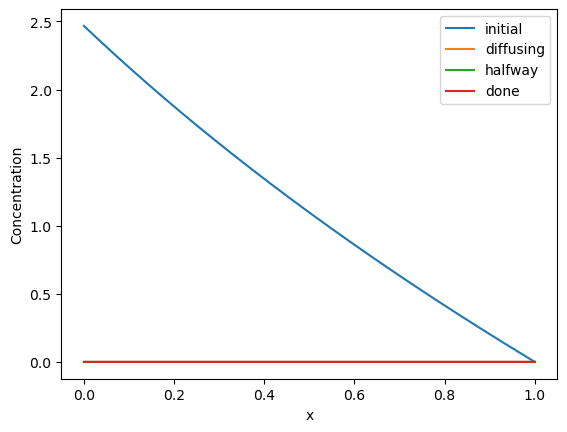

In [12]:
# Testing different C0

C0 = lambda x: np.arccos(x)**2  
D = lambda x: np.sin(x)
L = 1
k = 0.05
tf = 1

C = CN2(C0, D, L, k, tf)

x = np.linspace(0, L, C.shape[1])
plt.plot(x, C[0], label='initial')
plt.plot(x, C[10], label = 'diffusing')
plt.plot(x, C[250], label = 'halfway')
plt.plot(x, C[-1], label='done')
plt.xlabel('x')
plt.ylabel('Concentration')
plt.legend()
plt.show()

## Coupled Species with Boundary Influx

This system of equations takes the form: 

$$
\begin{align}
A \bold{C_A}^{n+1} &= B \bold{C_A}^n - \Delta t k \bold{C_A}^n \odot \bold{C_B}^n
\\[1em]
A \bold{C_B}^{n+1} &= B \bold{C_B}^n - \Delta t k \bold{C_A}^n \odot \bold{C_B}^n
\end{align}
$$

Here I'm using $\bold{C_A}$ To denote species A and $\bold{C_B}$ to denote species B because I'm already using $A$ and $B$ for the LHS and RHS matrices defined previously. $\odot$ is denoting component multiplication.

Because of the $\frac{\partial C_A}{\partial x} (L,t)=0$ boundary condition, $\frac{\partial^2 C_A}{\partial x^2}=0$ so the concentration of B cannot change at this end.


In [13]:
def CN3(CA0: Callable, CB0: Callable, CB_surf, DA, DB, L, k, tf, nspace=500, ntime=500):
    '''
    Uses CN propogation to find concentration profile of both species A and B over time. 
    Uses boundary condition C(0,0)=C(0,L); B(0,t)=B_surf, db/dx|(L,t)=0

    CA0: Function that represents the concentration profile at t=0.
    CB0: Same for CB
    CB_surf: CB fixed value at boundary x=0
    D: diffusion coefficient 
    L: length of rod
    tf: final time
    nspace: number of spatial steps
    ntime: number of timesteps
    '''
    dx = L/(nspace-1)
    dt = tf/(ntime-1)
    rA = (DA*dt)/(2*dx**2)
    rB = (DB*dt)/(2*dx**2)

    A_bands_A = np.zeros((3,nspace))
    A_bands_A[0,1:] = -rA
    A_bands_A[1,:] = 1+2*rA
    A_bands_A[2,:-1] = -rA

    A_bands_B = np.zeros((3,nspace))
    A_bands_B[0,1:] = -rB
    A_bands_B[1,:] = 1+2*rB
    A_bands_B[2,:-1] = -rB
    """ # Neumann boundary
    A_bands_B[0,-1] = 0      # upper diag
    A_bands_B[1,-1] = 1      # main diag
    A_bands_B[2,-2] = -1     # lower diag """



    B_A = np.diag((1-2*rA) * np.ones(nspace)) + np.diag(rA*np.ones(nspace-1), k=+1)+np.diag(rA*np.ones(nspace-1), k=-1)
    B_B = np.diag((1-2*rB) * np.ones(nspace)) + np.diag(rB*np.ones(nspace-1), k=+1)+np.diag(rB*np.ones(nspace-1), k=-1)

    CA = np.zeros((ntime+1, nspace)) # (n,i)
    CB = np.zeros((ntime+1, nspace))

    CA[0,:] = CA0(np.linspace(0, L, nspace))
    CB[0,:] = CB0(np.linspace(0, L, nspace))
    # Boundaries
    CA[0,0]=0
    CA[0,-1]=0
    CB[0,0]=CB_surf

    for n in range(ntime):
        # Initialize RHS
        RHS_A = B_A@CA[n] - dt*k*CA[n]*CB[n]
        RHS_B = B_B@CB[n] - dt*k*CA[n]*CB[n]
        # Solve
        CA[n+1,:]=la.solve_banded((1,1), A_bands_A, RHS_A)
        CB[n+1,:]=la.solve_banded((1,1), A_bands_B, RHS_B) # (1,1) denotes A has 1 diagonal row above main diag, 1 below.
        # Enforce Dirichlet
        CA[n+1,0]  = 0
        CA[n+1,-1] = 0
        CB[n+1,0]  = CB_surf

    return CA, CB

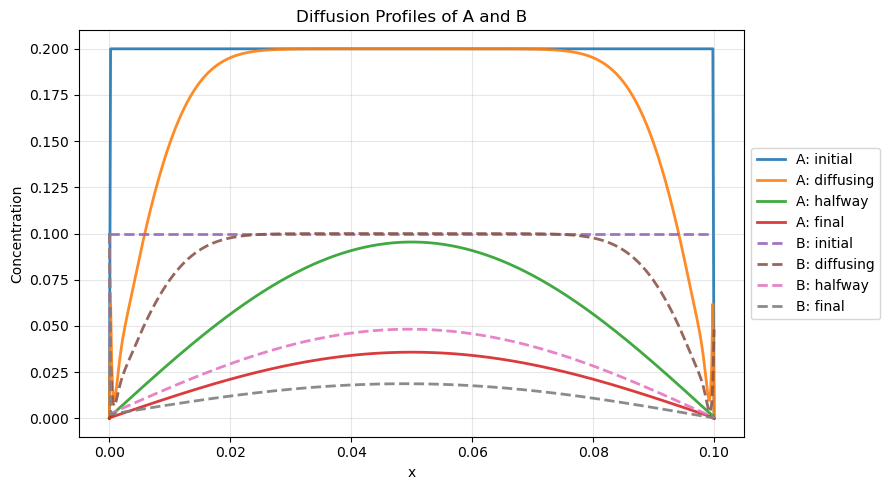

In [14]:
CA0 = lambda x: 0.2
CB0 = lambda x: 0.1
CB_surf = 0.1
DA = 0.2
DB = 0.2
L = 0.1
k = 1
tf = 0.01

CA, CB = CN3(CA0, CB0, CB_surf, DA, DB, L, k, tf)

x = np.linspace(0, L, CA.shape[1])


# plotting code source: ChatGPT
plt.figure(figsize=(9,5))

line_kwargs_A = dict(linewidth=2, alpha=0.9)
line_kwargs_B = dict(linewidth=2, alpha=0.9, linestyle='--')

plt.plot(x, CA[0],  label='A: initial',   **line_kwargs_A)
plt.plot(x, CA[10], label='A: diffusing', **line_kwargs_A)
plt.plot(x, CA[250],label='A: halfway',   **line_kwargs_A)
plt.plot(x, CA[-1], label='A: final',     **line_kwargs_A)

plt.plot(x, CB[0],  label='B: initial',   **line_kwargs_B)
plt.plot(x, CB[10], label='B: diffusing', **line_kwargs_B)
plt.plot(x, CB[250],label='B: halfway',   **line_kwargs_B)
plt.plot(x, CB[-1], label='B: final',     **line_kwargs_B)

plt.xlabel('x')
plt.ylabel('Concentration')
plt.title('Diffusion Profiles of A and B')
plt.grid(alpha=0.3)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()



In [15]:
# Verify Boundary
CB[:,0]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.